In [1]:
from causalsim import *
import metrics
from econml.metalearners import XLearner
from econml.dr import DRLearner
from econml.dml import CausalForestDML
from econml.metalearners import TLearner
from econml.metalearners import SLearner
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data Generation 
#### Simple model: Treatment effect for individual i: \tau_i = \beta * x_{i1} 

In [2]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data = simulation_simple(n = n, p = p, beta = beta, sigma = sigma)
print(data.head(10))

         X1       tau  Z   epsilon         Y
0  0.671500  0.671500  0  0.277931  0.277931
1 -0.115724 -0.115724  0  0.925993  0.925993
2 -0.974673 -0.974673  1  1.019850  0.045177
3 -0.310720 -0.310720  0 -0.037367 -0.037367
4 -0.563067 -0.563067  1 -0.061749 -0.624816
5  0.678151  0.678151  1 -1.481269 -0.803118
6  0.417968  0.417968  0  2.074636  2.074636
7  1.277249  1.277249  1 -1.474453 -0.197204
8  0.046950  0.046950  0  0.194326  0.194326
9  1.014275  1.014275  1  0.667144  1.681418


In [31]:
data = simulation_XLearner_1(100000, 20)
data[data['Z'] == 1]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,tau,Z,epsilon,Y
3,-0.388137,1.270786,-0.648979,-1.563212,-0.715780,0.386930,0.161851,1.311591,-0.142909,-0.246607,...,0.104347,-0.691890,-0.941618,0.997888,1.133774,0.422828,8,1,0.165395,2.505273
185,-0.831978,1.114297,-0.259491,0.616243,-0.653931,-0.320637,0.788632,1.196549,0.672433,1.705562,...,0.032612,1.643758,-1.027515,0.411225,0.684462,-1.664529,8,1,0.531219,25.472113
294,1.596881,2.566330,0.108522,-0.396544,-0.049585,-1.419875,-0.448564,0.497743,2.329034,-1.135572,...,0.196712,1.749010,-0.440305,-1.183970,0.323054,1.904847,8,1,1.247556,9.324675
327,-1.129209,-0.370976,1.009690,-0.036251,-1.096102,-0.589321,-1.013841,-0.219665,-1.923848,0.760998,...,0.217547,-0.264403,0.138912,0.240377,1.622075,-2.253293,0,1,-1.232992,4.748968
520,-2.377227,1.309736,1.257180,0.648206,0.339433,-1.323995,0.203852,-0.588856,0.126476,1.422666,...,-0.044672,-0.565012,0.613030,1.066807,0.943518,-0.303557,8,1,0.145784,21.454298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99547,1.077543,0.455969,0.545888,0.422706,1.327529,-0.025186,-0.712615,0.808004,0.995677,-0.131846,...,0.089690,-1.325906,-0.570184,-0.334248,2.176651,-1.304297,8,1,0.071314,-8.647653
99663,-0.536101,0.986115,-1.138125,0.088165,-1.296896,0.212085,0.160219,0.272521,-0.421622,-0.795445,...,0.034261,-1.141617,0.175289,1.447181,0.226856,0.217402,8,1,-0.127107,23.123909
99849,0.424981,0.409843,-1.622238,0.769410,0.806147,0.138257,-0.197555,-0.104835,-0.824191,0.311236,...,0.362328,-0.826406,0.374923,-1.566718,0.886380,0.214916,8,1,-0.824182,2.962142
99968,1.041252,-0.794696,-0.966460,0.338913,-1.135536,1.790988,-0.218161,0.368166,2.011249,0.400088,...,2.004997,-1.460556,0.965592,-0.281830,1.027264,0.928657,0,1,-2.045367,-3.932854


#### Categorical Model

In [3]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data_cat = simulation_categorical(n = n, p = p, beta = beta, sigma = sigma)
print(data_cat.head(10))

         X1  tau  Z   epsilon         Y
0  1.023143    1  1  0.056511  1.056511
1 -0.299046    0  0 -1.296546 -1.296546
2 -0.556704    0  1  0.245307  0.245307
3 -1.052029    0  1  0.940470  0.940470
4 -0.326775    0  0 -0.107064 -0.107064
5 -1.649053    0  1  0.280066  0.280066
6  0.300468    1  0  1.277158  1.277158
7 -0.728725    0  0 -1.486377 -1.486377
8  0.510106    1  0 -0.995065 -0.995065
9 -0.542140    0  0 -0.575164 -0.575164


#### Assigning variables for econml metalearner functions

In [32]:
X = data[[col for col in data.columns if col.startswith('X')]]
T = data['Z'] #treatment indicator
y = data['Y']
tau = np.array(data['tau'])

## Linear Regression

#### y ~ X + Z + X*Z

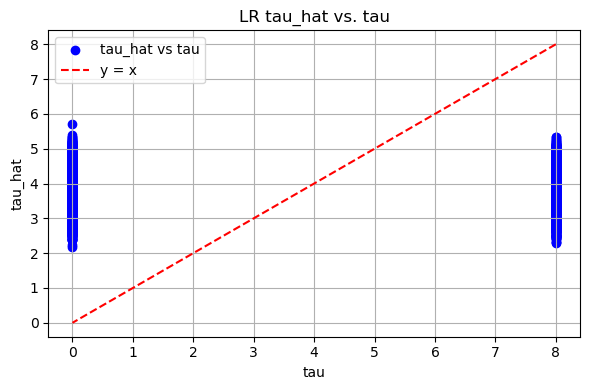

In [33]:
data_lr = data.copy()
data_lr['X1*Z'] = data_lr['X1'] * data_lr['Z'] #Setting interaction term
lr_xfit = data_lr[['X1', 'Z', 'X1*Z']]

lr = LinearRegression() #Fit linear regression
lr.fit(lr_xfit, data_lr['Y'])

bz = lr.coef_[1]
bzx = lr.coef_[2]

tau_hat_lr = bz + bzx*data['X1']


mse_lr, bias_lr, r2_lr = metrics.evaluate(tau, tau_hat_lr)

metrics.tau_plot(tau, tau_hat_lr, 'LR tau_hat vs. tau')

In [34]:
print(f'LR metrics:\nMse: {mse_lr}\nBias: {bias_lr}\nR2 {r2_lr}')

LR metrics:
Mse: 16.077365300853675
Bias: -0.14992311532500205
R2 -0.01080975714481447


## X-Learner

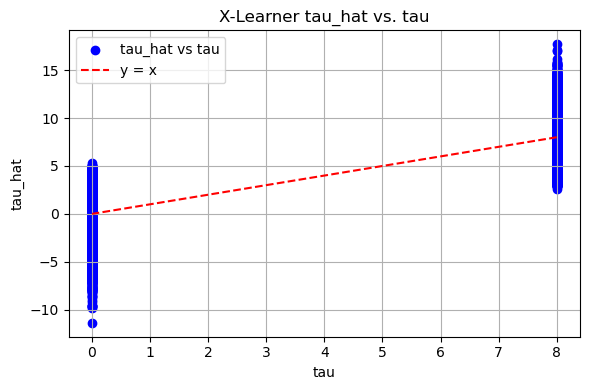

In [35]:
est = XLearner(models=LinearRegression())
est.fit(y, T, X=X)
tau_hat_x = est.effect(X)
mse_x, bias_x, r2_x = metrics.evaluate(tau, tau_hat_x)
metrics.tau_plot(tau, tau_hat_x, 'X-Learner tau_hat vs. tau')

In [36]:
print(f'X-learner metrics:\nMse: {mse_x}\nBias: {bias_x}\nR2 {r2_x}')

X-learner metrics:
Mse: 5.966587588678911
Bias: 0.10844779665861927
R2 0.6248710632223082


## S + T Learner

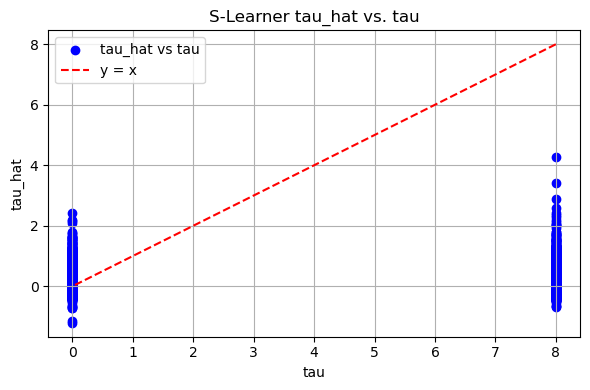

In [37]:
est = SLearner(overall_model=RandomForestRegressor())
est.fit(y, T, X=X)
tau_hat_s = est.effect(X)

mse_s, bias_s, r2_s = metrics.evaluate(tau, tau_hat_s)
metrics.tau_plot(tau, tau_hat_s, 'S-Learner tau_hat vs. tau')

In [12]:
print(f'S-learner metrics:\nMse: {mse_s}\nBias: {bias_s}\nR2 {r2_s}')

S-learner metrics:
Mse: 28.43370759052193
Bias: 3.557452560756266
R2 -0.7819250497421228


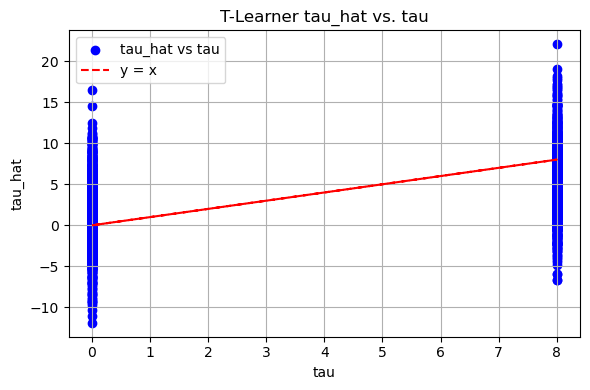

In [29]:
est = TLearner(models=LinearRegression())
est.fit(y, T, X=X)
tau_hat_t = est.effect(X)
tau_hat_t = Causal_TLearner(data, LinearRegression())
mse_t, bias_t, r2_t = metrics.evaluate(tau, tau_hat_t)
metrics.tau_plot(tau, tau_hat_t, 'T-Learner tau_hat vs. tau')

In [30]:
print(f'T-learner metrics:\nMse: {mse_t}\nBias: {bias_t}\nR2 {r2_t}')

T-learner metrics:
Mse: 20.666350686647814
Bias: 0.29502448891192434
R2 -0.29729794777600094


## DR-Learner

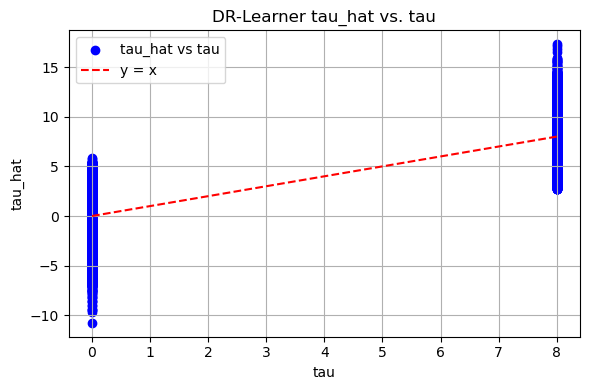

In [38]:
est = DRLearner()
est.fit(y, T, X=X, W=None)
tau_hat_dr = est.effect(X)

mse_dr, bias_dr, r2_dr = metrics.evaluate(tau, tau_hat_dr)
metrics.tau_plot(tau, tau_hat_dr, 'DR-Learner tau_hat vs. tau')

In [39]:
print(f'DR-learner metrics:\nMse: {mse_dr}\nBias: {bias_dr}\nR2 {r2_dr}')

DR-learner metrics:
Mse: 6.057295239284338
Bias: -0.06555749522442518
R2 0.6191681276626627


## Causal Forest

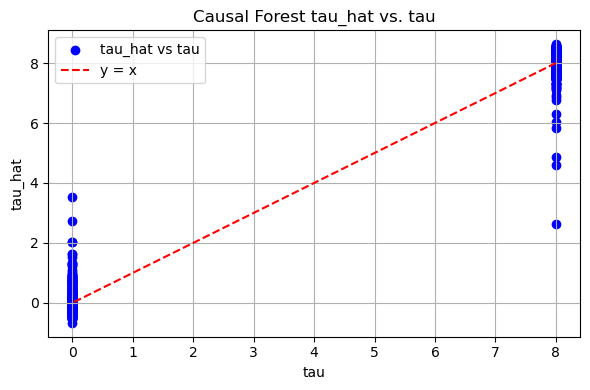

In [20]:
est = CausalForestDML(discrete_treatment=True)
est.fit(y, T, X=X, W=None)
tau_hat_cf = est.effect(X)

mse_cf, bias_cf, r2_cf = metrics.evaluate(tau, tau_hat_cf)
metrics.tau_plot(tau, tau_hat_cf, 'Causal Forest tau_hat vs. tau')

In [21]:
print(f'Causal Forest metrics:\nMse: {mse_cf}\nBias: {bias_cf}\nR2 {r2_cf}')

Causal Forest metrics:
Mse: 0.19406478642836708
Bias: -0.001220219330252791
R2 0.987838064975922
